In [83]:
import csv
import pandas as pd
from datetime import date, datetime
import matplotlib.pyplot as plt


In [123]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

In [92]:
import warnings
warnings.filterwarnings('ignore')

In [66]:
failed = pd.read_csv("data/fdic/failures.csv", encoding='latin1')
all = pd.read_csv("data/fdic/institutions.csv", encoding='latin1')

/var/folders/t1/wlm1x_7n48l030ngp1yv8sdw0000gn/T/ipykernel_39692/3772587738.py:2: DtypeWarning: Columns (92,93,94,95,96,97) have mixed types. Specify dtype option on import or set low_memory=False.
  all = pd.read_csv("data/fdic/institutions.csv", encoding='latin1')


I then filter the institutions data from 142 columns (variables) down to columns I want to focus on. Selection is based on literature review and previous research 
See institutions_definitions.csv for more detailed variable defintiions for all 142 columns. Here are the noteable ones I chose to include:

* CERT: FDIC Certificate, a unique number assigned by the FDIC used to identify institutions and for the issuance of insurance certificates.
* ACTIVE: Institution Status, a number indicating the status of an institution. 
                                1='Institutions that are currently open and insured by the FDIC'
                                0='Institution closed or not insured by FDIC'
* BKCLASS: Institution Class, a classification code assigned by the FDIC based on the institution's charter type (commercial bank or savings institution), 
                                charter agent (state or federal), Federal Reserve membership status (Fed member, Fed non-member) and its primary federal 
                                regulator (state chartered institutions are subject to both federal and state supervision). 
    N - Commercial bank, national (federal) charter, Fed member, and supervised by the Office of the Comptroller of the Currency (OCC)
    NM - Commercial bank, state charter, Fed non-member, and supervised by the Federal Deposit Insurance Corporation (FDIC)
    OI - Insured U.S. branch of a foreign chartered institution (IBA) and supervised by the OCC or FDIC
    SB - Federal savings banks, federal charter, supervised by the OCC or before July 21,2011 the Office of Thrift Supervision (OTS)
    SI - State chartered stock savings banks, supervised by the FDIC
    SL - State chartered stock savings and loan associations, supervised by the FDIC or before July 21,2011 the OTS
    SM - Commercial bank, state charter, Fed member, and supervised by the Federal Reserve Bank (FRB)
    NC - Noninsured non-deposit commercial banks and/or trust companies regulated by the OCC, a state, or a territory
    NS - Noninsured stock savings bank supervised by a state or territory
    CU - state or federally chartered credit unions supervised by the National Credit Union Association (NCUA).
* ESTYMD: Established Date, the date on which the institution or branch began operations.
* ASSET: Total assets, the sum of all assets owned by the institution including cash, loans, securities, bank premises and other assets. This total does not include off-balance-sheet accounts.
* EQ: Equity capital, total equity capital (includes preferred and common stock, surplus and undivided profits).
* DEP: total deposits, the sum of all deposits including demand deposits, money market deposits, other savings deposits, time deposits and deposits in foreign offices.
* OFFICES: A branch/office is any location, or facility, of a financial institution, including its main office, where deposit accounts are opened, deposits are accepted,
             checks paid, and loans granted. Some branches include, but are not limited to, brick and mortar locations, detached or attached drive-in facilities, seasonal 
             offices, offices on military bases or government installations, paying/receiving stations or units, nondeposit offices, Internet and PhoneBanking locations 
             where a customer can open accounts, make deposits and borrow money. A branch does not include Automated Teller Machines (ATM), Consumer Credit Offices, 
             Contractual Offices, Customer Bank Communication Terminals (CBCT), Electronic Fund Transfer Units (EFTU), and Loan Production Offices Summary of Deposits 
             information is required for each insured office located in any State, the District of Columbia, the Commonwealth of Puerto Rico or any U.S. territory or 
             possession such as Guam or the U.S. Virgin Islands, without regard to the location of the main office.
* ROA: Return on assets (ROA), net income after taxes and extraordinary items (annualized) as a percent of average total assets.
* NETINC: Net income, net interest income plus total noninterest income plus realized gains (losses) on securities and extraordinary items, less total noninterest expense, 
            loan loss provisions and income taxes.
* MUTUAL: Ownership Type, banking institutions fall into one of two ownership types, stock or non-stock. An institution which sells stock to raise capital is called a stock
            institution. It is owned by the shareholders who benefit from profits earned by the institution. A non-stock institution, or mutual institution, is owned
            and controlled solely by its depositors. A mutual does not issue capital stock.


In [90]:
cols = ["CERT", "NAME", "STNAME", "CITY", "ACTIVE", "BKCLASS", "ESTYMD","ASSET","NETINC", "EQ", "DEP", "ROA","MUTUAL","OFFICES"]
data = all[cols]
data.sort_values(by="ASSET", ascending=False).head(n=10)
# data.dtypes


,CERT,NAME,STNAME,CITY,ACTIVE,BKCLASS,ESTYMD,ASSET,NETINC,EQ,DEP,ROA,MUTUAL,OFFICES
10137,628,"JPMorgan Chase Bank, National Association",Ohio,Columbus,1,N,01/01/1824,3.385581e+09,38886000.0,317802000.0,2.459921e+09,1.566640,0.0,5133.0
26978,3510,"Bank of America, National Association",North Carolina,Charlotte,1,N,10/17/1904,2.465234e+09,24191000.0,229009000.0,1.979677e+09,1.309557,0.0,4020.0
10006,3511,"Wells Fargo Bank, National Association",South Dakota,Sioux Falls,1,N,01/01/1870,1.704891e+09,18038000.0,161448000.0,1.392993e+09,1.419341,0.0,4395.0
10611,7213,"Citibank, National Association",South Dakota,Sioux Falls,1,N,06/16/1812,1.657372e+09,11716000.0,166243000.0,1.286104e+09,0.911454,0.0,946.0
11135,6548,U.S. Bank National Association,Ohio,Cincinnati,1,N,07/13/1863,6.571836e+08,4911887.0,59540236.0,5.299069e+08,0.967683,0.0,2306.0
27729,6384,"PNC Bank, National Association",Delaware,Wilmington,1,N,01/01/1804,5.531140e+08,4879805.0,47355996.0,4.311488e+08,1.174485,0.0,2401.0
16445,33124,Goldman Sachs Bank USA,New York,New York,1,SM,08/30/1990,5.381270e+08,4380000.0,53304000.0,3.750360e+08,1.149812,0.0,5.0
5206,9846,Truist Bank,North Carolina,Charlotte,1,NM,01/01/1872,5.350000e+08,4294000.0,61609000.0,4.117000e+08,1.044348,0.0,2006.0
1427,33869,"Wachovia Bank, National Association",North Carolina,Charlotte,0,N,01/11/1994,5.100830e+08,4247000.0,67340000.0,3.555740e+08,0.757375,0.0,NaN
13781,4297,"Capital One, National Association",Virginia,Mclean,1,N,05/22/1933,4.687798e+08,4430840.0,48936195.0,3.737548e+08,1.272870,0.0,285.0


Data cleanup: 

In [115]:
current_date = datetime(2024, 1, 1)
date_format = "%m/%d/%Y"

# convert string to date object
data['ESTYMD'] = pd.to_datetime(data['ESTYMD'], format="%m/%d/%Y")

# new column
data['AGE'] = (current_date - data['ESTYMD']).dt.days
data['AGE']

# fixing NaN
print("there are " + str(len(data[data.isna().any(axis=1)].index)) + " rows with NaN values") 

# drop only rows with more than 2 NaN values
data_cleaned = data.dropna(thresh=len(data.columns)-2)

data[data.isna().any(axis=1)]
data_cleaned[data_cleaned.isna().any(axis=1)]

# fill rest with 0
data_cleaned = data_cleaned.fillna(0)

data_cleaned[data_cleaned.isna().any(axis=1)]


there are 4045 rows with NaN values


,CERT,NAME,STNAME,CITY,ACTIVE,BKCLASS,ESTYMD,ASSET,NETINC,EQ,DEP,ROA,MUTUAL,OFFICES,AGE


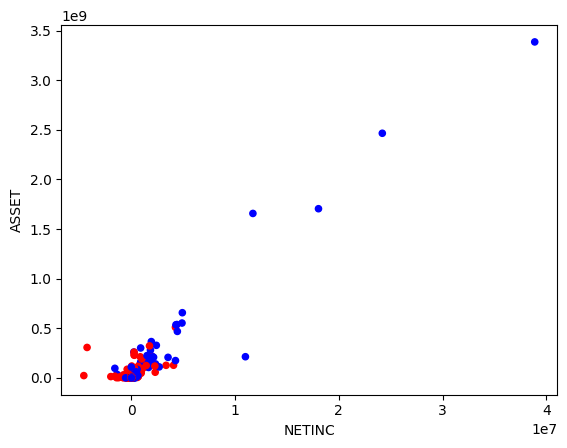

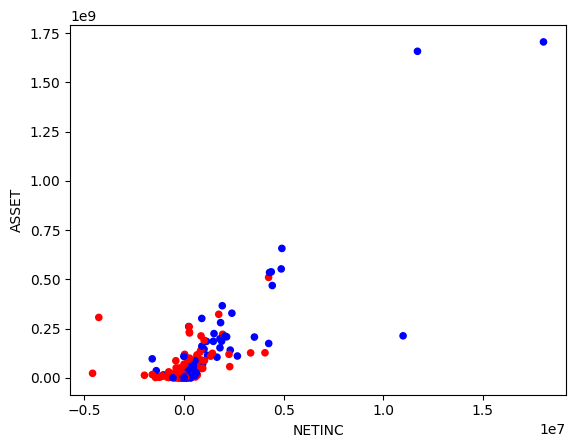

In [116]:
colors = data_cleaned['ACTIVE'].map({1: 'blue', 0: 'red'})
graph1 = data_cleaned.plot.scatter(x="NETINC", y="ASSET", c=colors)


# drop large vals
data_drop_asset = data_cleaned[data_cleaned['ASSET'] < 2.0*(10**9)]
data_drop_asset.sort_values(by="ASSET", ascending=False)

colors_new = data_drop_asset['ACTIVE'].map({1: 'blue', 0: 'red'})
graph2 = data_drop_asset.plot.scatter(x="NETINC", y="ASSET", c=colors_new)


Set X independent variables and y dependent variable, create test and train sets:

In [117]:
X = data_cleaned.drop(['ACTIVE', 'NAME', 'CERT', 'STNAME', 'CITY', 'ESTYMD'], axis=1)
y = data_cleaned['ACTIVE'] 

# create dummy variables for BKCLASS
X = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# verifying lol
print("indpt var training data size is " + str(len(X_train)))
print("indpt var test data size is " + str(len(X_test)))
print()
print("dpt var training data size is " + str(len(y_train)))
print("dpt var testing data size is " + str(len(y_test)))

indpt var training data size is 19056
indpt var test data size is 4765

dpt var training data size is 19056
dpt var testing data size is 4765


building the model:

In [118]:
X[X.isna().any(axis=1)]

,ASSET,NETINC,EQ,DEP,ROA,MUTUAL,OFFICES,AGE,BKCLASS_NC,BKCLASS_NM,BKCLASS_NS,BKCLASS_OI,BKCLASS_SB,BKCLASS_SI,BKCLASS_SL,BKCLASS_SM


In [119]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

predictions:

In [120]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)


Accuracy: 0.8169989506820566
Confusion Matrix:
 [[3841   26]
 [ 846   52]]


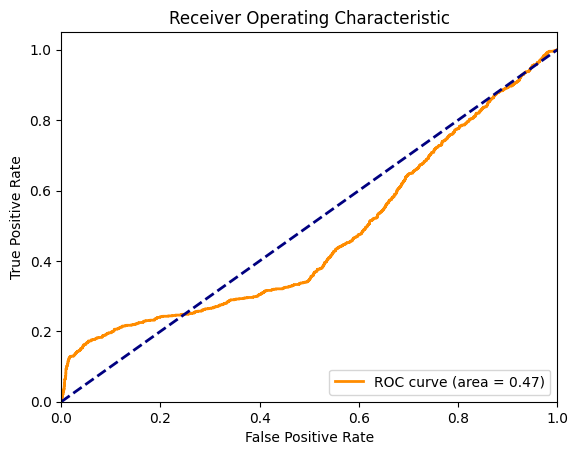

In [125]:
y_scores = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()